### Necessary Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from utils import *

plt.style.use("default")
plt.rcParams["figure.figsize"] = (6, 4)

### System Model

**Defining Parameters**

In [2]:
# System parameters
area = [-25, 25]  # area of the simulation m^2
M = 4  # number of users
N = 1  # number of base stations

eta = 4  # path loss exponent
Pt = np.linspace(-80, -20, 30)  # transmit power in dBm
Pt_lin = 10 ** (Pt / 10) / 1000  # transmit power in linear scale

bandwidth = 1e9  # bandwidth in Hz
noise = -170 + 10 * np.log10(bandwidth)  # noise power in dBm
noise_lin = 10 ** (noise / 10) / 1000  # noise power in linear scale
K = 5 * 10**4  # number of bits to be transmitted

**Placing Users**

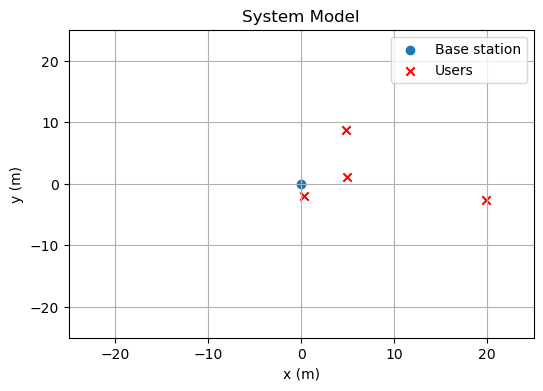

In [3]:
from matplotlib.markers import MarkerStyle

# Create a network with base station at the origin
bs = np.array([[0, 0]])
d = np.array([20, 10, 5, 2])  # distance from base station

theta = np.random.uniform(0, 2 * np.pi, size=M)
x = d * np.cos(theta)
y = d * np.sin(theta)
users = np.column_stack((x, y))

# Plot the network
plt.scatter(bs[:, 0], bs[:, 1], label="Base station")
plt.scatter(
    users[:, 0],
    users[:, 1],
    label="Users",
    marker=MarkerStyle("x"),
    color="r",
)
plt.legend()
plt.grid()
plt.title("System Model")
plt.xlim([area[0], area[1]])
plt.ylim([area[0], area[1]])
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.savefig("system_model.pdf", bbox_inches="tight")
plt.show()

In [4]:
distance_mat = np.sqrt(np.sum((users - bs[0]) ** 2, axis=1)).reshape(-1, 1)

print("Distance Matrix:")
print(distance_mat)

Distance Matrix:
[[20.]
 [10.]
 [ 5.]
 [ 2.]]


### Generate Channel Matrices

**Rayleigh Fading Coefficients and Gain Matrix**

In [5]:
h_mat = (
    np.sqrt(distance_mat ** (-eta))
    * (np.random.randn(M, K // 2) + 1j * np.random.randn(M, K // 2))
    / np.sqrt(2)
)

print("Channel Matrix:")
print(h_mat)

gain_mat = np.abs(h_mat) ** 2

print("\nGain Matrix:")
print(gain_mat.mean(axis=1))

Channel Matrix:
[[ 1.53243499e-05-2.36838660e-03j -1.41776415e-03+1.98689705e-03j
   1.32411204e-03-1.71075929e-03j ... -1.23285746e-03+3.83595149e-04j
  -1.19393142e-03+2.75018707e-04j  9.49760254e-04+7.09011117e-04j]
 [-5.43127774e-04-1.15739494e-02j  6.00778100e-03+1.02924168e-02j
  -2.15354750e-03-1.72451156e-03j ... -3.81123587e-03+5.74079335e-03j
  -7.01180602e-03+2.56655825e-05j  7.50129507e-03-6.63904899e-03j]
 [ 4.07703849e-02-6.09567494e-02j -3.66567562e-02-2.53630506e-02j
   1.13306795e-02+1.61109136e-02j ... -4.16594086e-02+1.43136650e-02j
   1.73421345e-02-5.05087700e-03j -3.25886188e-02+2.08568192e-02j]
 [ 1.39346348e-01-1.06522954e-01j -1.98194066e-01+9.75867719e-02j
  -1.15197404e-01+1.02927619e-01j ... -1.43046983e-01-7.61947813e-02j
  -1.51362039e-01+1.36800295e-01j -2.88236061e-02-4.53348195e-02j]]

Gain Matrix:
[6.19989808e-06 9.97509289e-05 1.59540675e-03 6.23942491e-02]


**Noise Matrix**

In [6]:
noise_mat = (
    np.sqrt(noise_lin)
    * (np.random.randn(M, K // 2) + 1j * np.random.randn(M, K // 2))
    / np.sqrt(2)
)

print("Noise Matrix:")
print(noise_mat.mean(axis=1))

Noise Matrix:
[-1.00953629e-08-1.81001139e-09j -3.58690461e-09+1.45108520e-08j
  9.14722136e-10+1.52120843e-08j  5.13139797e-09-8.73647440e-09j]


### Allocation Factors

**Employed Power Allocation Scheme**

Exhaustive search is a method used to find the optimal solution to a problem by considering all possible solutions. In the context of power allocation, an exhaustive search approach can be used to determine the optimal power allocation that maximizes performance. For example, in NOMA (Non-Orthogonal Multiple Access) systems, an exhaustive search approach can be used to find the optimal power allocation that maximizes sum capacity. However, this approach can be computationally expensive and may not be practical for large-scale systems.

In [7]:
# Create all possible combinations of allocation factors
alpha_combinations = []
for i in range(1, 101, 5):
    for j in range(1, 101 - i, 5):
        for k in range(1, 101 - i - j, 5):
            l = 100 - i - j - k
            new_alpha = np.array([i / 100, j / 100, k / 100, l / 100])
            if np.abs(np.sum(new_alpha) - 1) < 1e-9 and np.all(new_alpha > 0):
                alpha_combinations.append(new_alpha)

In [8]:
noma_sumrates, noma_userrates = zip(
    *[
        calculate_noma_rate(M, K, Pt_lin, combination, gain_mat, noise_lin)
        for combination in alpha_combinations
    ]
)
noma_sumrates = np.array(noma_sumrates)
noma_userrates = np.array(noma_userrates)

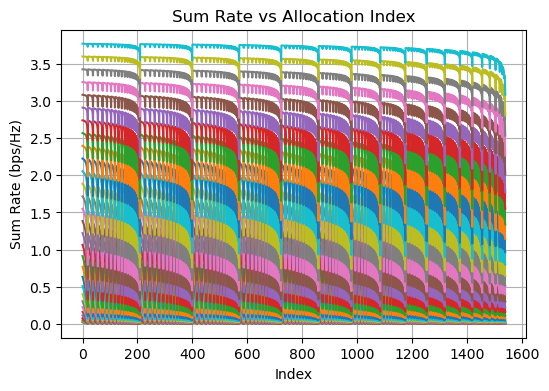

In [9]:
# Plot NOMA sumrates vs index
plt.plot(noma_sumrates)
plt.xlabel("Index")
plt.ylabel("Sum Rate (bps/Hz)")
plt.title("Sum Rate vs Allocation Index")
plt.grid()
plt.savefig("sumrate_vs_index.pdf", bbox_inches="tight")
plt.show()

In [10]:
# Define power allocation coefficients
# to count user unfairness
alpha = np.array([0.55, 0.3, 0.15, 0.05])

# Find the allocation matrix yielding the highest achievable rate
max_index = np.argmax(noma_sumrates)
max_alpha = alpha_combinations[max_index]

print("Maximum Achievable Sum Rate:")
print(max(noma_sumrates[max_index]), "bps/Hz")

print("\nOptimal Allocation Matrix:")
print(max_alpha)

Maximum Achievable Sum Rate:
3.7725363610488145 bps/Hz

Optimal Allocation Matrix:
[0.01 0.06 0.46 0.47]


### User Fairness Comparison

**Is maximum sum capacity the best metric?**

While maximizing the sum rate can lead to high overall system performance, it may not always result in fair allocation of resources among users. In some cases, a few users with good channel conditions may be allocated a large amount of resources, while other users with poor channel conditions may receive very little. This can result in user unfairness, where some users experience high data rates while others experience low data rates.

In [11]:
_, unfair_userrates = calculate_noma_rate(
    M, K, Pt_lin[-1], max_alpha, gain_mat, noise_lin
)
_, fair_userrates = calculate_noma_rate(M, K, Pt_lin[-1], alpha, gain_mat, noise_lin)

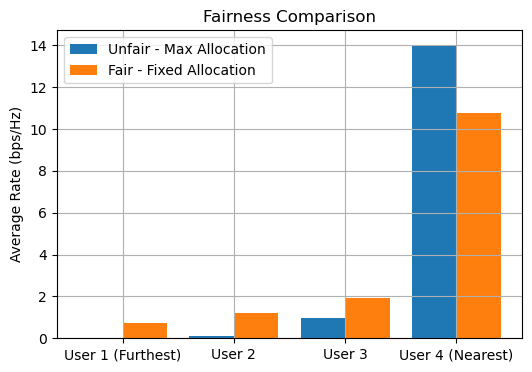

In [12]:
# Define user labels and x positions
user_labels = ["User 1 (Furthest)", "User 2", "User 3", "User 4 (Nearest)"]
x_positions = np.arange(len(user_labels))
bar_width = 0.4

# Each axis of userrates is the rate of a user
fig, ax = plt.subplots()
rects1 = ax.bar(
    x_positions - bar_width / 2,
    unfair_userrates.mean(axis=1),
    bar_width,
    label="Unfair - Max Allocation",
)
rects2 = ax.bar(
    x_positions + bar_width / 2,
    fair_userrates.mean(axis=1),
    bar_width,
    label="Fair - Fixed Allocation",
)
plt.xticks(x_positions, user_labels)
plt.ylabel("Average Rate (bps/Hz)")
plt.title("Fairness Comparison")
plt.legend()
plt.grid()
plt.savefig("fairness_comparison.pdf", bbox_inches="tight")
plt.show()

In [13]:
# Define bandwidth allocation coefficients
beta_ofdma = (bandwidth / M) / bandwidth  # Bandwidth per user for OFDMA

### NOMA vs OFDMA Capacity

In [14]:
noma_sumrate, _ = calculate_noma_rate(M, K, Pt_lin, alpha, gain_mat, noise_lin)
ofdma_sumrate, _ = calculate_ofdma_rate(M, K, Pt_lin, gain_mat, noise_lin, beta_ofdma)

**Why does NOMA perform better than OFDMA at higher SNR?**

At low Signal-to-Noise Ratio (SNR), OFDMA performs slightly better than NOMA. This is because in NOMA, users suffer from interference due to simultaneous transmission, while OFDMA users do not experience any such interference. This means that at low SNR, the interference in NOMA can significantly affect the performance of the system.

However, at high SNR, NOMA outperforms OFDMA by offering high capacity. This is because NOMA can serve multiple users simultaneously in the same frequency band, while OFDMA assigns different frequency bands to different users. This means that at high SNR, the interference in NOMA is less significant and the system can take advantage of the simultaneous transmission to achieve higher capacity.

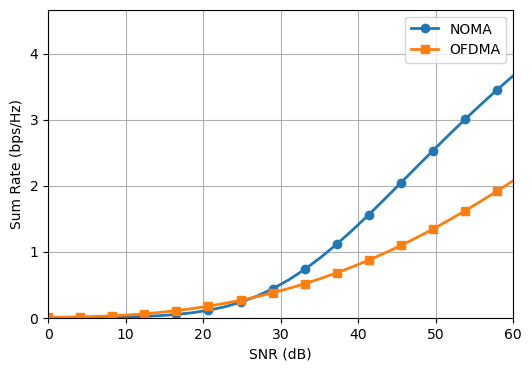

In [15]:
# Plot the sum capacity of NOMA and OFDMA vs SNR
SNR = Pt - noise
plt.figure()
plt.plot(SNR, noma_sumrate, marker="o", linewidth=2, markevery=2)
plt.plot(SNR, ofdma_sumrate, marker="s", linewidth=2, markevery=2)
plt.xlabel("SNR (dB)")
plt.ylabel("Sum Rate (bps/Hz)")

# plt.title("Capacity of NOMA vs OFDMA")
plt.xlim([min(SNR), max(SNR)])
plt.ylim([0, max(noma_sumrate) + 1])
plt.grid(True)
plt.legend(["NOMA", "OFDMA"])
plt.savefig("noma_vs_ofdma.pdf", bbox_inches="tight")
plt.show()

### Outage Probability

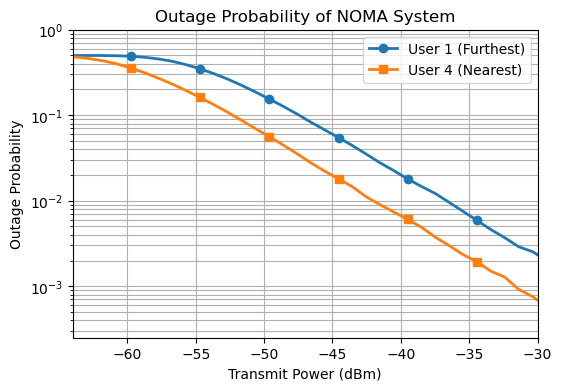

In [16]:
Pt_temp = np.linspace(-80, 0, 80)  # transmit power in dBm
Pt_lin_temp = 10 ** (Pt_temp / 10) / 1000  # transmit power in linear scale

# Compute rates of each user
prob_u1 = np.zeros(len(Pt_temp))
prob_u4 = np.zeros(len(Pt_temp))

for i in range(len(Pt_temp)):
    gamma_u1 = (alpha[0] * Pt_lin_temp[i] * gain_mat[0]) / (
        noise_lin
        + alpha[1] * Pt_lin_temp[i] * gain_mat[0]
        + alpha[2] * Pt_lin_temp[i] * gain_mat[0]
        + alpha[3] * Pt_lin_temp[i] * gain_mat[0]
    )
    gamma_u14 = (alpha[0] * Pt_lin_temp[i] * gain_mat[3]) / (
        noise_lin
        + alpha[1] * Pt_lin_temp[i] * gain_mat[3]
        + alpha[2] * Pt_lin_temp[i] * gain_mat[3]
        + alpha[3] * Pt_lin_temp[i] * gain_mat[3]
    )
    gamma_u4 = (alpha[3] * Pt_lin_temp[i] * gain_mat[3]) / (noise_lin)

    rate_u1 = np.log2(1 + gamma_u1)
    rate_u4 = np.log2(1 + gamma_u4)
    rate_u14 = np.log2(1 + gamma_u14)

    # Check for outage
    for k in range(K // 2):
        if rate_u1[k] < 0.01 / 5:
            prob_u1[i] += 1
        if (rate_u4[k] < 0.5) or (rate_u14[k] < 0.5):
            prob_u4[i] += 1

prob_outage_u1 = prob_u1 / K
prob_outage_u4 = prob_u4 / K

# Plot outage probability vs transmit power (dBm)
plt.figure()
plt.semilogy(Pt_temp, prob_outage_u1, marker="o", linewidth=2, markevery=5)
plt.semilogy(Pt_temp, prob_outage_u4, marker="s", linewidth=2, markevery=5)
plt.grid(which="both")
plt.xlabel("Transmit Power (dBm)")
plt.ylabel("Outage Probability")
plt.title("Outage Probability of NOMA System")
plt.legend(["User 1 (Furthest)", "User 4 (Nearest)"])
plt.xlim([-64, -30])
plt.ylim([0.25e-3, 1])
plt.savefig("outage_probability.pdf", bbox_inches="tight")
plt.show()

### Saturation in Far User's Rate

**Why does Saturation occur?**

In Non-Orthogonal Multiple Access (NOMA), the far user’s rate saturates after a certain power level because of the near-far effect. The near-far effect is a phenomenon that occurs when the channel gains of the users are significantly different. In NOMA, more power allocation is given to the user with poor channel gain to improve the quality of the signal received by that user. As the near channel gain is more, he can successfully decode the signal even at low power levels. However, as the power level increases, the far user’s rate saturates because of the limited power allocation.

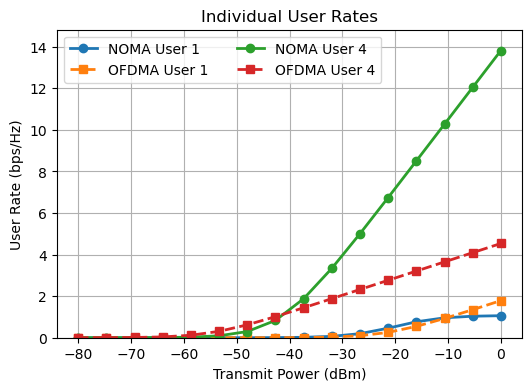

In [17]:
Pt_temp = np.linspace(-80, 0, 16)  # transmit power in dBm
Pt_lin_temp = 10 ** (Pt_temp / 10) / 1000  # transmit power in linear scale

noma_userrates = np.zeros((len(Pt_temp), 2))
ofdma_userrates = np.zeros((len(Pt_temp), 2))

for i in range(len(Pt_temp)):
    _, noma_rates = calculate_noma_rate(
        M, K, Pt_lin_temp[i], alpha, gain_mat, noise_lin
    )
    noma_userrates[i] = [noma_rates[0, -1], noma_rates[3, -1]]
    _, ofdma_rates = calculate_ofdma_rate(
        M, K, Pt_lin_temp[i], gain_mat, noise_lin, beta_ofdma
    )
    ofdma_userrates[i] = [ofdma_rates[0, -1], ofdma_rates[3, -1]]

# Plot the user capacity of NOMA and OFDMA vs SNR for user 1 and user 4
plt.figure()
plt.plot(Pt_temp, noma_userrates[:, 0], "o-", linewidth=2, label="NOMA User 1")
plt.plot(Pt_temp, ofdma_userrates[:, 0], "s--", linewidth=2, label="OFDMA User 1")
plt.plot(Pt_temp, noma_userrates[:, 1], "o-", linewidth=2, label="NOMA User 4")
plt.plot(Pt_temp, ofdma_userrates[:, 1], "s--", linewidth=2, label="OFDMA User 4")
plt.xlabel("Transmit Power (dBm)")
plt.ylabel("User Rate (bps/Hz)")
plt.legend(loc="upper left", ncol=2)
plt.title("Individual User Rates")
plt.ylim([0, max(noma_userrates.max(), ofdma_userrates.max()) + 1])
plt.grid(True)
plt.savefig("individual_user_rates.pdf", bbox_inches="tight")
plt.show()